# Churn Prediction

### Importing all libraries

In [71]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

### Import the Dataset

In [5]:
df = pd.read_csv(r"C:\Users\Aish\OneDrive\Desktop\Projects\Churn\Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Preprocessing
1. Checking for Null values
2. Correct the data types
3. Remove unneccesary columns

In [7]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


The 'TotalCharges' is as 'object' datatype. This is converted to 'float' dtype.

In [19]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df['TotalCharges']

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [23]:
df = df.drop('customerID', axis=1)

The customerID does not affect the model. So it is removed.

### Exploratory Data Analysis (EDA)
1. Dataset Shape
2. Feature Distribution

In [26]:
print('Dataset Shape: ', df.shape)

Dataset Shape:  (7043, 20)


In [35]:
df['Churn'].unique()

array(['No', 'Yes'], dtype=object)

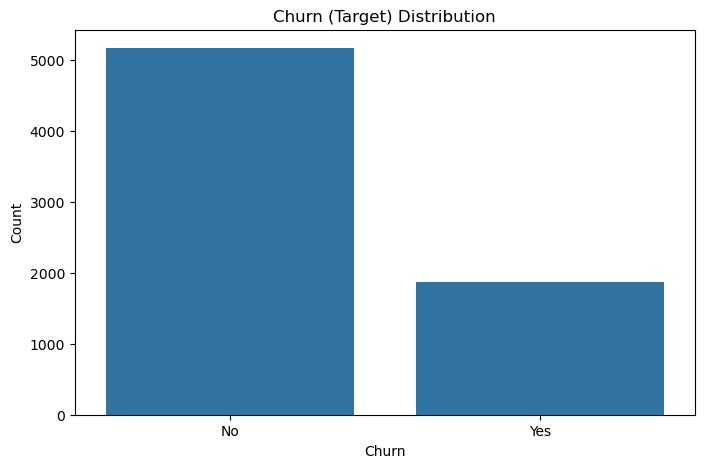

In [37]:
plt.figure(figsize=(8,5))
sns.countplot(x='Churn', data=df)
plt.title('Churn (Target) Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

It is clear that the data is imbalanced and skewed. (73% and 27%)

### Statistical Analysis
1. Correlation for Numeric Features
2. Chi-square Test for Categorical Features

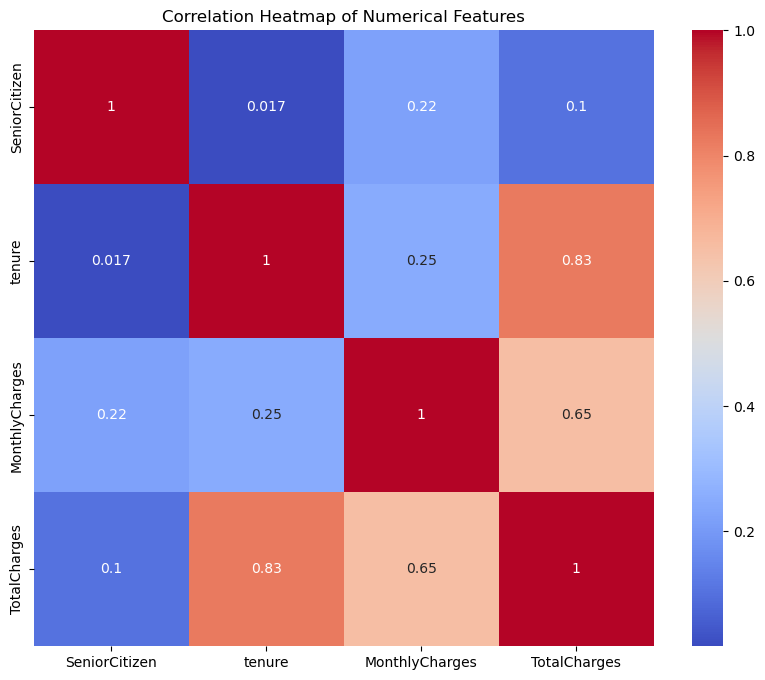

In [47]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

**Inference:**
- There is weak or no correlation between SeniorCitizen and other variables suggesting that may not a strong predictor.
- There is strong correlation between tenure and TotalCharges suggesting that customers who stay longer accumulate more charges. This may influence churn.
- TotalCharges and MonthlyCharges have a positive correlation indicating that monthly cost drives the overall costs.

In [55]:
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'Churn':
        contingency_table = pd.crosstab(df[col], df['Churn'])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        print(f"Chi-square test for {col}: p-value = {p:.6f}")

Chi-square test for gender: p-value = 0.486579
Chi-square test for Partner: p-value = 0.000000
Chi-square test for Dependents: p-value = 0.000000
Chi-square test for PhoneService: p-value = 0.338783
Chi-square test for MultipleLines: p-value = 0.003464
Chi-square test for InternetService: p-value = 0.000000
Chi-square test for OnlineSecurity: p-value = 0.000000
Chi-square test for OnlineBackup: p-value = 0.000000
Chi-square test for DeviceProtection: p-value = 0.000000
Chi-square test for TechSupport: p-value = 0.000000
Chi-square test for StreamingTV: p-value = 0.000000
Chi-square test for StreamingMovies: p-value = 0.000000
Chi-square test for Contract: p-value = 0.000000
Chi-square test for PaperlessBilling: p-value = 0.000000
Chi-square test for PaymentMethod: p-value = 0.000000


**Inference:**
- Gender, PhoneService are not significant features so may not be strong predictors.
- Other features show a significant relationship with churn

### Data Processing
1. Encoding Categorical Variables
2. Split the features and target into training and testing data
3. Scale numerical features
4. Apply SMOTE (Synthetic Minority Oversampling Technique) to resample the data.

In [59]:
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

In [61]:
df.head(7)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1
5,0,0,0,0,8,1,2,1,0,0,2,0,2,2,0,1,2,99.65,820.50,1
6,1,0,0,1,22,1,2,1,0,2,0,0,2,0,0,1,1,89.10,1949.40,0


In [63]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
print('Shape of X_train: ', X_train.shape)
print('\nShape of X_test: ', X_test.shape)

Shape of X_train:  (5634, 19)

Shape of X_test:  (1409, 19)


In [67]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [79]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print('Resampled training class distribution: ', np.bincount(y_train))

Resampled training class distribution:  [4138 4138]


### Training ML Models and Evaluating
1. Define a function for evaluation metrics
2. Train different ML models and compare performance

In [84]:
def evaluate_model(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    return metrics


Logistic Regression Performance:
Accuracy: 0.76
Precision: 0.53
Recall: 0.83
F1: 0.64
ROC-AUC: 0.86

Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.73      0.82      1036
         Yes       0.53      0.83      0.64       373

    accuracy                           0.76      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409



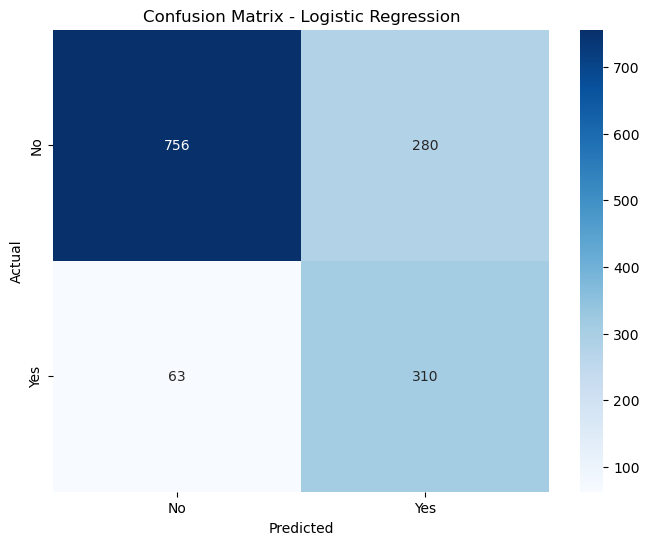

In [132]:
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
lr_model.fit(X_train, y_train)
lr_metrics = evaluate_model(lr_model, X_test, y_test, 'Logistic Regression')


Decision Tree Classifier Performance:
Accuracy: 0.49
Precision: 0.32
Recall: 0.82
F1: 0.46
ROC-AUC: 0.59

Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.37      0.51      1036
         Yes       0.32      0.82      0.46       373

    accuracy                           0.49      1409
   macro avg       0.58      0.59      0.49      1409
weighted avg       0.71      0.49      0.50      1409



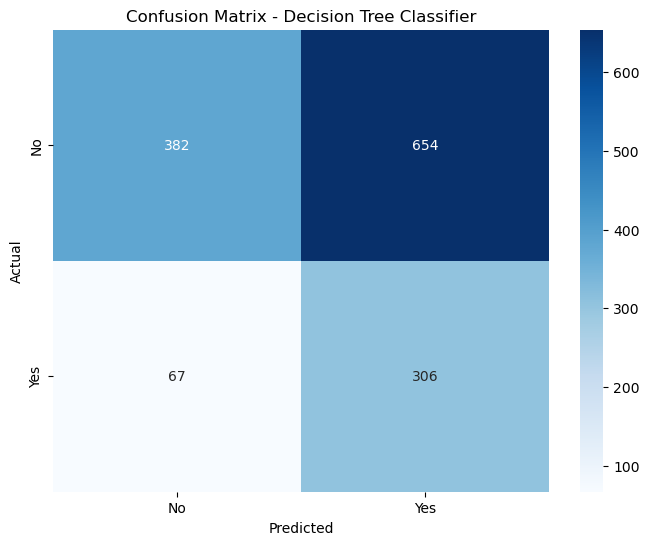

In [134]:
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)
dt_metrics = evaluate_model(dt_model, X_test, y_test, 'Decision Tree Classifier')


Random Forest Performance:
Accuracy: 0.58
Precision: 0.38
Recall: 0.87
F1: 0.53
ROC-AUC: 0.79

Classification Report:
              precision    recall  f1-score   support

          No       0.91      0.48      0.63      1036
         Yes       0.38      0.87      0.53       373

    accuracy                           0.58      1409
   macro avg       0.64      0.68      0.58      1409
weighted avg       0.77      0.58      0.60      1409



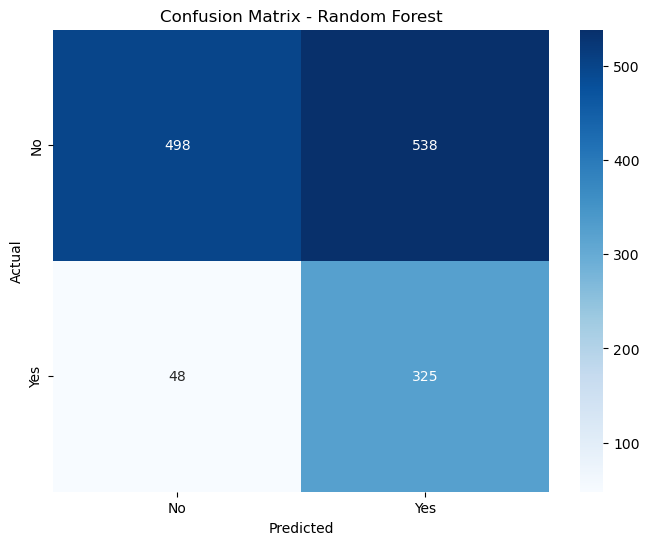

In [136]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
rf_metrics = evaluate_model(rf_model, X_test, y_test, 'Random Forest')


SVM Performance:
Accuracy: 0.76
Precision: 0.54
Recall: 0.72
F1: 0.61
ROC-AUC: 0.83

Classification Report:
              precision    recall  f1-score   support

          No       0.88      0.78      0.83      1036
         Yes       0.54      0.72      0.61       373

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409



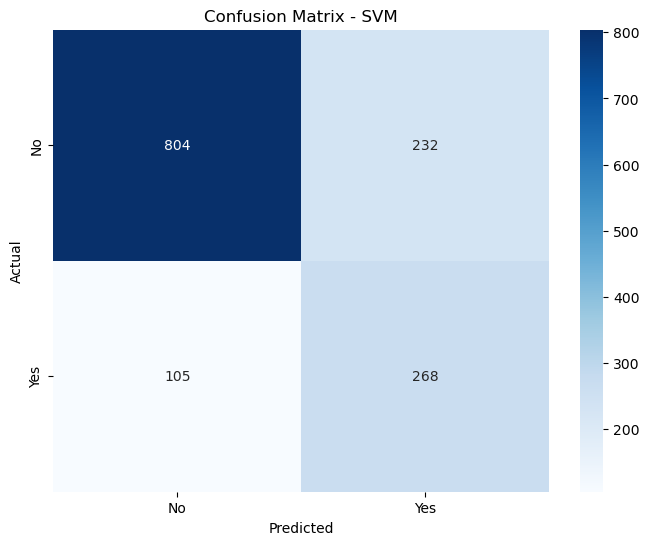

In [138]:
svm_model = SVC(probability=True, random_state=42, class_weight='balanced')
svm_model.fit(X_train, y_train)
svm_metrics = evaluate_model(svm_model, X_test, y_test, 'SVM')

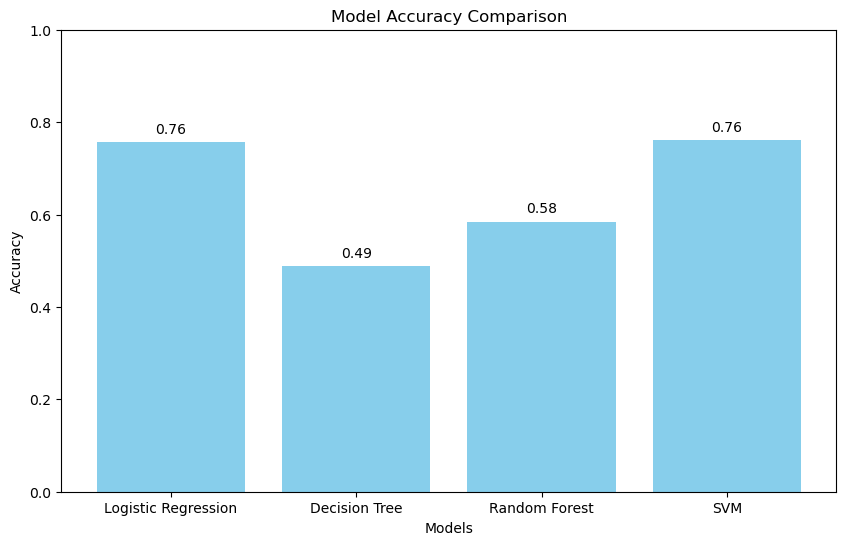

In [140]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM']
accuracies = [lr_metrics['Accuracy'], dt_metrics['Accuracy'], rf_metrics['Accuracy'], svm_metrics['Accuracy']]
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
plt.show()

**Applying Hyperparameter Tuning**


Tuned Logistic Regression Performance:
Accuracy: 0.76
Precision: 0.53
Recall: 0.83
F1: 0.64
ROC-AUC: 0.86

Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.73      0.82      1036
         Yes       0.53      0.83      0.64       373

    accuracy                           0.76      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409



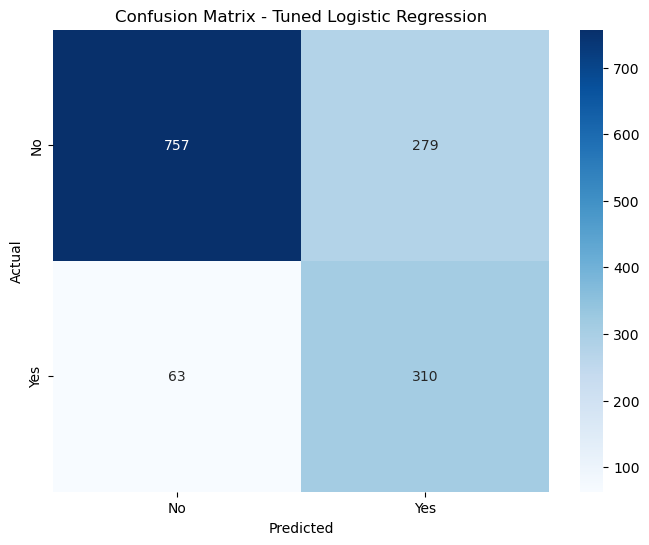

Best LR parameters: {'C': 10, 'max_iter': 100}


In [143]:
lr_params = {'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200]}
lr_grid = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'), lr_params, cv=5, scoring='f1')
lr_grid.fit(X_train, y_train)
lr_best = lr_grid.best_estimator_
lr_metrics_tuned = evaluate_model(lr_best, X_test, y_test, "Tuned Logistic Regression")
print("Best LR parameters:", lr_grid.best_params_)


Tuned Decision Tree Performance:
Accuracy: 0.52
Precision: 0.34
Recall: 0.88
F1: 0.50
ROC-AUC: 0.57

Classification Report:
              precision    recall  f1-score   support

          No       0.90      0.40      0.55      1036
         Yes       0.34      0.88      0.50       373

    accuracy                           0.52      1409
   macro avg       0.62      0.64      0.52      1409
weighted avg       0.76      0.52      0.54      1409



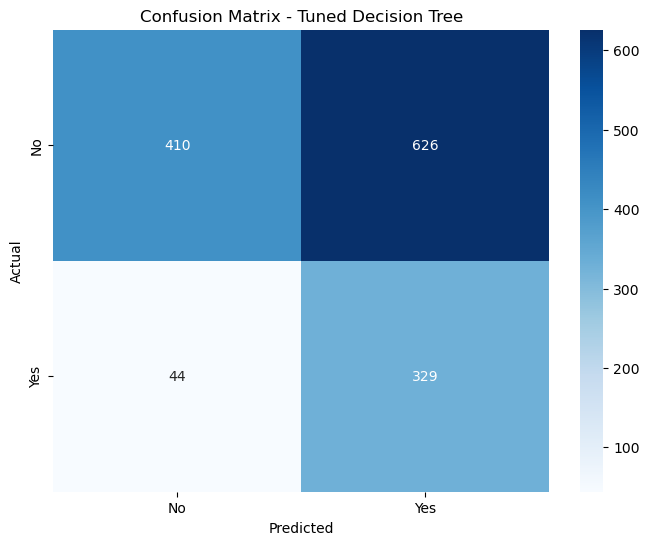

Best DT parameters: {'max_depth': 10, 'min_samples_split': 5}


In [145]:
dt_params = {'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42, class_weight='balanced'), dt_params, cv=5, scoring='f1')
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_
dt_metrics_tuned = evaluate_model(dt_best, X_test, y_test, "Tuned Decision Tree")
print("Best DT parameters:", dt_grid.best_params_)


Tuned Random Forest Performance:
Accuracy: 0.59
Precision: 0.38
Recall: 0.87
F1: 0.53
ROC-AUC: 0.80

Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.49      0.64      1036
         Yes       0.38      0.87      0.53       373

    accuracy                           0.59      1409
   macro avg       0.65      0.68      0.59      1409
weighted avg       0.77      0.59      0.61      1409



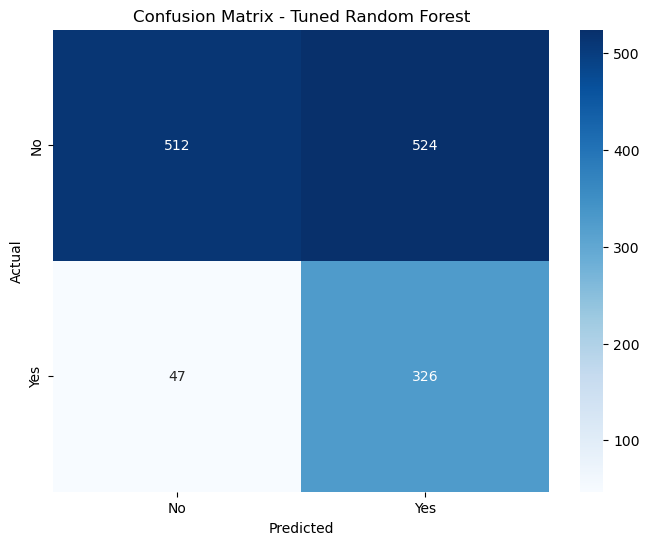

Best RF parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [147]:
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), rf_params, cv=5, scoring='f1')
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
rf_metrics_tuned = evaluate_model(rf_best, X_test, y_test, "Tuned Random Forest")
print("Best RF parameters:", rf_grid.best_params_)


Tuned SVM Performance:
Accuracy: 0.76
Precision: 0.54
Recall: 0.67
F1: 0.60
ROC-AUC: 0.80

Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.80      0.83      1036
         Yes       0.54      0.67      0.60       373

    accuracy                           0.76      1409
   macro avg       0.71      0.73      0.71      1409
weighted avg       0.78      0.76      0.77      1409



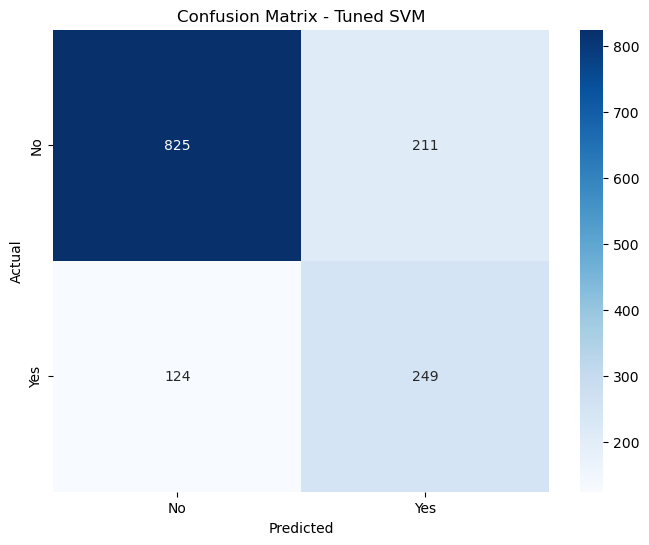

Best SVM parameters: {'C': 10, 'kernel': 'rbf'}


In [149]:
svm_params = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42, class_weight='balanced'), svm_params, cv=5, scoring='f1')
svm_grid.fit(X_train, y_train)
svm_best = svm_grid.best_estimator_
svm_metrics_tuned = evaluate_model(svm_best, X_test, y_test, "Tuned SVM")
print("Best SVM parameters:", svm_grid.best_params_)

Performed hyperparameter tuning (GridSearchCV) on all models. Observed no significant performance gain over the base model, indicating that the default parameters were already close to optimal for this dataset.

Based on the performance metrics, **Logistic Regression is the best model.** Here the goal is to catch churners (minimize false negative). Thus, the LR model is better with higher recall (0.83), roc-auc score (0.86) and f1 score (0.64). These metrics help evaluate that LR model is robust for imbalanced classification in this case.

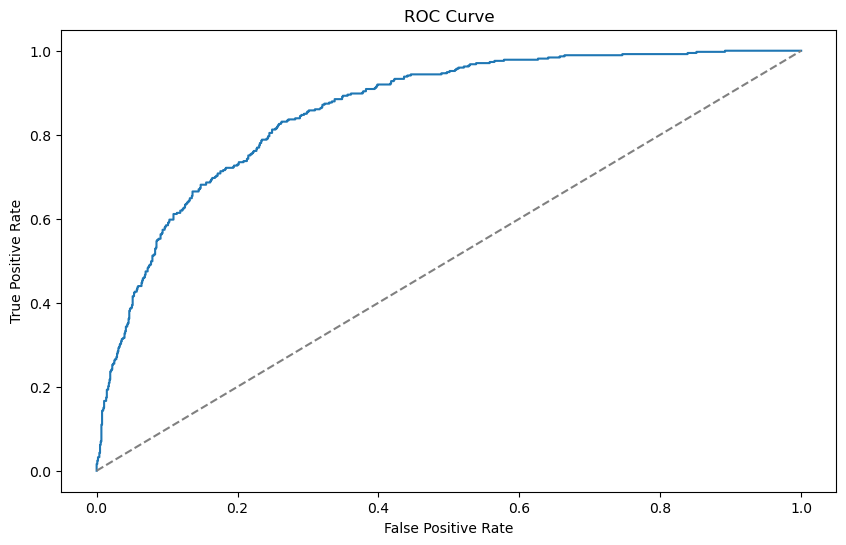

In [163]:
lr_proba = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, lr_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The curve rises quickly towards the top-left corner indicating that model seperates churners from non-churners. 

In [171]:
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='f1')
print('Cross validation F1 score: ', cv_scores)
print('Mean CV F1 score: ', cv_scores.mean())

Cross validation F1 score:  [0.77192982 0.77112676 0.77822814 0.78753541 0.79262673]
Mean CV F1 score:  0.7802893730571443


The model is performing consistently well across all folds indicating a lower variance. The mean F1 score is 0.78 which is comparitively higher. This ensures the generalization of the model. 

### Plotting Feature Importance

C:\Users\Aish\AppData\Local\Temp\ipykernel_1576\2313063792.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(15), x='Importance (abs)', y='Feature', palette='viridis')


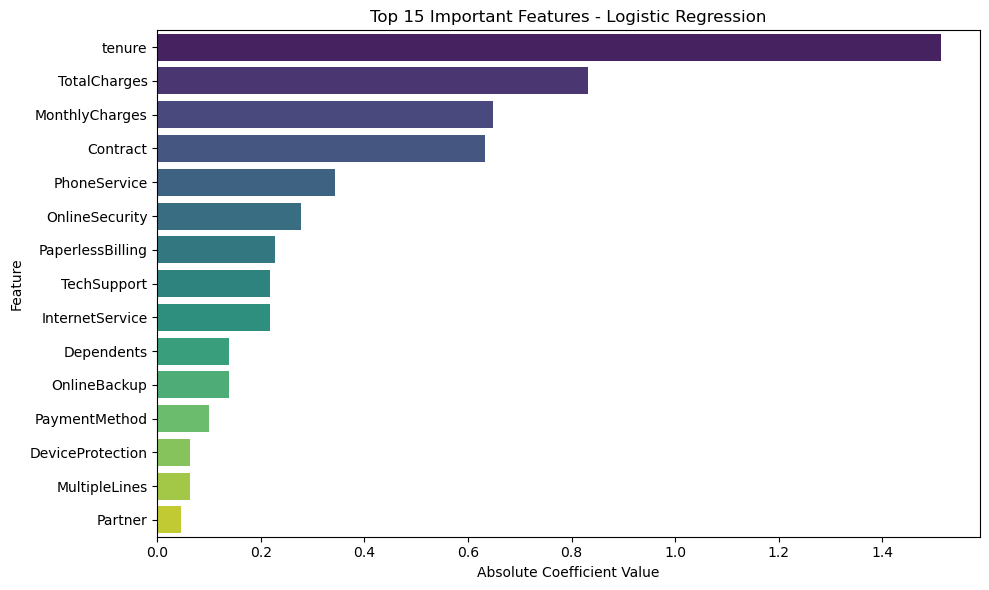

In [188]:
feature_names = X.columns
coefficients = lr_model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance (abs)': np.abs(coefficients)
})
feature_importance = feature_importance.sort_values(by='Importance (abs)', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(15), x='Importance (abs)', y='Feature', palette='viridis')
plt.title('Top 15 Important Features - Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Save the Predictions

In [178]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': lr_model.predict(X_test)})
predictions.to_csv(r"C:\Users\Aish\OneDrive\Desktop\Projects\Churn\predictions.csv", index=False)

### Exporting the Final Model

In [200]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

categorical_cols = df.select_dtypes(include=['object']).columns 
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns 

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OrdinalEncoder(), categorical_cols)
])

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

X_train = pd.DataFrame(X_train, columns=X.columns)
pipeline.fit(X_train, y_train)

joblib.dump(pipeline, 'churn_prediction_pipeline.pkl')

['churn_prediction_pipeline.pkl']